# Compute AUC ROC for the best model
Based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from scipy import interp
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
rcParams.update({'font.size': 18})
colors = ['#222a20', '#e6c138', '#869336',  '#44472f', '#eef9c8']

In [15]:
# Get all results files
files_name = 'both'
path_data = '/home/om18/Documents/KCL/May 10 19 - Classifying the DIPs/results/'
files = os.listdir(path_data)
files= [i for i in files if files_name in i]

In [16]:
files = [i for i in files if files_name in i]
df = pd.read_csv(f'{path_data}{files[0]}')
df.head()

,train_loss_0,val_loss_0,train_accuracy_0,val_accuracy_0,train_pred_proba0,y_train_set_0,val_pred_proba0,y_val_set_0,best_val_loss_0,best_val_acc_0,...,train_pred_proba4,y_train_set_4,val_pred_proba4,y_val_set_4,best_val_loss_4,best_val_acc_4,test_pred_proba4,prediction_test_set_4,y_test_set_4,accuracy_test_4
0,6.377833,0.693788,48.717949,48.275862,0.754949,1.0,0.621844,1.0,0.682668,55.172414,...,0.370317,0.0,0.136471,0.0,0.561112,65.517241,0.757950,1.0,1.0,53.333333
1,5.700890,0.696578,54.700855,48.275862,0.315015,1.0,0.453296,1.0,NaN,NaN,...,0.263937,0.0,0.404537,0.0,NaN,NaN,0.494100,0.0,0.0,NaN
2,5.425036,0.704571,62.820513,48.275862,0.908146,1.0,0.490143,1.0,NaN,NaN,...,0.372421,0.0,0.797292,1.0,NaN,NaN,0.241051,0.0,1.0,NaN
3,4.975713,0.719517,66.239316,48.275862,0.102976,0.0,0.742321,1.0,NaN,NaN,...,0.418550,1.0,0.553849,0.0,NaN,NaN,0.600326,1.0,1.0,NaN
4,5.192814,0.718537,60.256410,48.275862,0.719364,0.0,0.168684,0.0,NaN,NaN,...,0.234479,0.0,0.840233,1.0,NaN,NaN,0.404395,0.0,1.0,NaN


In [17]:
# Read all files of interest and find the one with the lowest loss
loss = 100
loss_per_model = []
for f in files:
    df = pd.read_csv(f'{path_data}{f}')
    loss_per_fold = []
    for fold in np.arange(0,5):
        loss_per_fold.append(df[f'best_val_loss_{fold}'].values[0])
    loss_per_model.append(np.mean(loss_per_fold))
    
model_best_loss = np.where(loss_per_model == np.min(loss_per_model))[0][0]
files[model_best_loss]

'results_v2_both_resnet18_lr_1_00E-3_(72.4).csv'

In [18]:
def compute_ROC_and_AUC(y_true_, probas_):
    # Discard the NANs from the dataframe
    discard_nans = np.argwhere(np.isnan(y_true_))
    if discard_nans.size > 0:
        discard_nans = discard_nans[0][0]
        y_true_ = y_true_[:discard_nans]
        probas_ = probas_[:discard_nans]
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_true_, probas_)
    tpr_interp = interp(mean_fpr, fpr, tpr)
#     tpr_interp[-1][0] = 0.0
    auc_fold = auc(fpr, tpr)
    # Compute accuracy
    acc = accuracy_score(y_true_, probas_>.5)
    return fpr, tpr, auc_fold, tpr_interp, acc

In [19]:
# https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
#'#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'
colors = ['#000000', '#4363d8', '#e6194B','#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0',  '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', ]

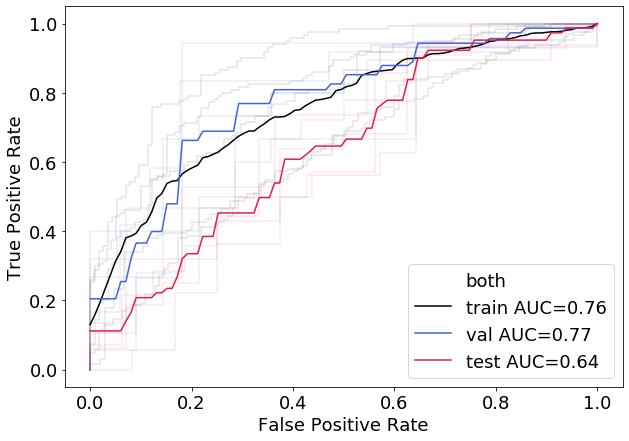

In [20]:
# Print the ROCs of the file with the lowest loss
aucs_train, aucs_val, aucs_test = [], [], []
mean_fpr = np.linspace(0, 1, 100)
df = pd.read_csv(f'{path_data}{files[model_best_loss]}')
fig, ax = plt.subplots(1,1,figsize=(10,7))
tprs_train, tprs_val, tprs_test = [], [], []
accs_train, accs_val, accs_test=  [], [], []
for fold in np.arange(0,5):
    probas_train = df[f'train_pred_proba{fold}'].values
    y_true_train = df[f'y_train_set_{fold}'].values
    probas_val = df[f'val_pred_proba{fold}'].values
    y_true_val = df[f'y_val_set_{fold}'].values
    probas_test = df[f'test_pred_proba{fold}'].values
    y_true_test = df[f'y_test_set_{fold}'].values
    # Compute train ROC curve and area the curve
    fpr_train, tpr_train, auc_fold_train, tpr_interp_train, acc_fold_train = compute_ROC_and_AUC(y_true_train, probas_train)
    accs_train.append(acc_fold_train)
    aucs_train.append(auc_fold_train)
    tprs_train.append(tpr_interp_train)
    # Compute val ROC curve and area the curve
    fpr_val, tpr_val, auc_fold_val, tpr_interp_val, acc_fold_val = compute_ROC_and_AUC(y_true_val, probas_val)
    accs_val.append(acc_fold_val)
    aucs_val.append(auc_fold_val)
    tprs_val.append(tpr_interp_val)
    # Compute test ROC curve and area the curve
    fpr_test, tpr_test, auc_fold_test, tpr_interp_test, acc_fold_test = compute_ROC_and_AUC(y_true_test, probas_test)
    accs_test.append(acc_fold_test)
    aucs_test.append(auc_fold_test)
    tprs_test.append(tpr_interp_test)
    
    # For legend
    aucs_train_mean = np.mean(aucs_train)
    aucs_val_mean = np.mean(aucs_val)
    aucs_test_mean = np.mean(aucs_test)
    accs_train_mean = np.mean(accs_train)
    accs_val_mean = np.mean(accs_val)
    accs_test_mean = np.mean(accs_test)
    #Plot
    ax.plot(fpr_train, tpr_train, c=colors[0], alpha=.1)
    ax.plot(fpr_val, tpr_val, c=colors[1], alpha=.1)
    ax.plot(fpr_test, tpr_test, c=colors[2], alpha=.1)
    
mean_tpr_train = np.mean(tprs_train, axis=0)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_test = np.mean(tprs_test, axis=0)
ax.plot([],[],label=files_name, linestyle = 'None')
ax.plot(mean_fpr, mean_tpr_train, c=colors[0], alpha=1, label = f'train AUC={aucs_train_mean:.2f}')# acc={accs_train_mean:.2f}')
ax.plot(mean_fpr, mean_tpr_val, c=colors[1], alpha=1, label = f'val AUC={aucs_val_mean:.2f}')# acc={accs_val_mean:.2f}')
ax.plot(mean_fpr, mean_tpr_test, c=colors[2], alpha=1, label = f'test AUC={aucs_test_mean:.2f}')# acc={accs_test_mean:.2f}')
ax.legend(fontsize=18, loc= 'lower right')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
fig.savefig(f'results/roc_best_{files_name}.png')

In [21]:
20000/60

333.3333333333333

In [22]:
333/24

13.875